#### In this problem we use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.

Here, We are particularly interested in detecting faces in a given image.

#### To use the model first, we need to import the model and its supporting files for the model to function. 

We see the below steps to import the model.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/AdvCNN/Face_Detection_Files')

### Import MobileNet model given in file `mn_model.py`

In [5]:
### Import MobileNet model given in file `mn_model.py`
from mn_model import mn_model

Using TensorFlow backend.


In [6]:
!sudo pip install Pillow==2.6.0

In [7]:
!pip install scipy==0.19.1

In [0]:
from scipy.misc import imresize

In [0]:
from face_generator import BatchGenerator

### Import the BatchGenerator and SSDLoss functions in given files `face_generator.py`, `keras_ssd_loss` and `ssd_box_encode_decode_utils.py` as well, used in MobileNet model

In [0]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

In [0]:
import warnings
warnings.filterwarnings("ignore")

from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored

from mn_model import mn_model
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

# training parameters
from keras import backend as K
import scipy.misc as sm


## Set the parameters for the model

#### We need to customize the model parameters according to our problem as given below.

#### Set n_classes (no.of classes) = 2, as we are interested in only face detection. 
#### `Face` will be one class and everything else comes under other class (we can call it as `background`)

#### Set class_names = ["background", "face"]

In [0]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

det_model_path = "./"

### Now, we have imported the model and its dependencies. The next thing is to import the dataset for the model to train on. For this, we are using the WIDER FACE dataset. 

#### To make the dataset available follow the steps given below.


1. Create a folder in your google drive for this project. 

2. Download the train and test dataset files given in .zip format into your drive folder 

3. Set the project path variable according to the folders you created to use for this project in your google drive. 

      `project_path = "/content/drive/My Drive/Project"`

4. Now, as we mount the drive the images will be available to use for training and testing but in zip format.

5. So, lets extract the images from the zipfiles by using the code given of zipfile module.







In [0]:
project_path = "/content/drive/My Drive/AdvCNN/Face_Detection_Files/"

In [0]:
train_images_path = project_path + 'WIDER_train.zip'
test_images_path = project_path + 'WIDER_val.zip'

In [0]:
import zipfile
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [0]:
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

### Now, the images are available. The next thing we need is to get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 

#### Follow the below steps to get those labels available.


Load the  '' `wider_train_small.npy`'' file given to check the information given about the dataset. In this file you can see the information about each image in the dataset in a list with following elemets:
      

        1.   Image filename (str)
        2.   Image filename (str)
        3.   Image size (list) [height, width]
        4.   List of bounding box co-ordinates and Class label (list) [[a,b,c,d], Class label, ...]
        
        where,
        a,b,c,d are the four co-ordinates of the bounding box
        Class label is the position of object as mentioned in `class_names` list above.

In [13]:
pwd

'/content/drive/My Drive/AdvCNN/Face_Detection_Files'

In [0]:
data = np.load('./wider_train_small.npy').item()
#data = np.load('./wider_train_small.npy',allow_pickle=True).item()

In [15]:
for k, v in data.items():
    print(k, v)

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg ['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]
4--Dancing/4_Dancing_Dancing_4_108.jpg ['WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_108.jpg', 'WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_108.jpg', [300, 300], [[476, 526, 332, 366], 1], [[739, 759, 478, 504], 1], [[974, 995, 481, 506], 1], [[792, 809, 478, 499], 1], [[844, 860, 490, 512], 1], [[900, 918, 499, 522], 1], [[686, 703, 482, 505], 1], [[639, 655, 488, 509], 1], [[590, 604, 483, 504], 1], [[553, 566, 492, 510], 1], [[500, 515, 480, 500], 1], [[238, 251, 480, 497], 1], [[283, 295, 490, 508], 1], [[322, 335, 480, 498], 1], [[345, 357, 484, 501], 1], [[361, 375, 484, 505], 1], [[199, 214, 473, 493], 1], [[161, 174, 477, 495], 1], [[77, 91, 475, 496], 1], [[34, 47, 472, 490], 1],

In [16]:
### Printed first element to check the above given information.

for key in data:
    print (key)
    print (data[key])
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


 As we can see from the above output all the information mentioned above is there for all the images.

### Now, load the files `wider_trian.npy` and `wider_val.npy`

In [0]:
train_data = 'wider_train_small.npy'
test_data = 'wider_val_small.npy'

#x = np.load(train_data, allow_pickle=True)
x = np.load(train_data)

### Now, call the imported model with the given parameters and freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [18]:
# build the keras model
# this model is not retrained, we are doing it from scratch 

K.clear_session()
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

====> Model Specific data
====> Height, Width, Channels : 512 512 3
Instructions for updating:
Colocations handled automatically by placer.


#### Write code to freeze all the layers in the above model with names not having ''`detection`'' word as prefix.

In [19]:
a=0
for layers in model.layers:
    #print(layers.name)
    layers.trainable = False
    if('detection' in layers.name):
        layers.trainable = True
        print(layers.name)
        a = a+1

detection_conv6_1
detection_conv6_1_bn
detection_conv6_1_nonlin
detection_conv6_2_conv_dw_1
detection_conv6_2_conv_dw_1_bn
detection_conv6_2_conv_dw_1_relu
detection_conv6_2_conv_pw_1
detection_conv6_2_conv_pw_1_bn
detection_conv6_2_conv_pw_1_relu
detection_conv7_1
detection_conv7_1_bn
detection_conv7_1_nonlin
detection_conv7_2_conv_dw_2
detection_conv7_2_conv_dw_2_bn
detection_conv7_2_conv_dw_2_relu
detection_conv7_2_conv_pw_2
detection_conv7_2_conv_pw_2_bn
detection_conv7_2_conv_pw_2_relu
detection_conv8_1
detection_conv8_1_bn
detection_conv8_1_nonlin
detection_conv8_2_conv_dw_3
detection_conv8_2_conv_dw_3_bn
detection_conv8_2_conv_dw_3_relu
detection_conv8_2_conv_pw_3
detection_conv8_2_conv_pw_3_bn
detection_conv8_2_conv_pw_3_relu
detection_conv9_1
detection_conv9_1_bn
detection_conv9_1_nonlin
detection_conv9_2_conv_dw_4
detection_conv9_2_conv_dw_4_bn
detection_conv9_2_conv_dw_4_relu
detection_conv9_2_conv_pw_4
detection_conv9_2_conv_pw_4_bn
detection_conv4_3_norm
detection_conv9_2_

In [20]:
223-138

85

### After making the model ready for transfer learning, load the weights of the model given in file ''`mobilenet_1_0_224_tf.h5`''

In [21]:
len(model.layers)

223

In [0]:
model.load_weights('mobilenet_1_0_224_tf.h5', by_name=True)

#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples. Run the below code.

In [36]:
!pip install numpy==1.16.1

     |████████████████████████████████| 17.3MB 4.9MB/s 
ERROR: yellowbrick 0.9.1 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 2.6.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 2.6.0 which is incompatible.
ERROR: mir-eval 0.5 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: magenta 0.3.19 has requirement Pillow>=3.4.2, but you'll have pillow 2.6.0 which is incompatible.
ERROR: librosa 0.6.3 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: cvxpy 1.0.15 has requirement scipy>=1.1.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: bokeh 1.0.4 has requirement pillow>=4.0, but you'll have pillow 2.6.0 which is incompatible

In [23]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


### Now, lets setup things for training by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model

In [0]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 10

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### Lets add early stopping and model checkpoint layers on validation loss with some patience values and using fit_generator function to train the model on data generated batch-by-batch by a Python generator, `train_generator` object as generator.


We are using checkpoint to save the best model based on validation accuracy.

#### Write code for early_stopping and model_checkpoint layers. Using model.fit_generator train the model and save the best weight file.

In [39]:
os.mkdir('/content/drive/My Drive/AdvCNN/Model/')

FileExistsError: ignored

In [0]:
modelFilePath = '/content/drive/My Drive/AdvCNN/Model/'

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc_fg = ModelCheckpoint(filepath=modelFilePath+'best_weights_fg.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
es_fg = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

In [45]:
model.fit_generator(train_generator, steps_per_epoch=100, callbacks=[mc_fg,es_fg], validation_data=(val_generator), validation_steps=25, epochs=num_epochs)

Epoch 1/10
100/100 [==============================] - 229s 2s/step - loss: 0.1870 - val_loss: 0.2150

Epoch 00001: val_loss improved from inf to 0.21499, saving model to /content/drive/My Drive/AdvCNN/Model/best_weights_fg.h5
Epoch 2/10
100/100 [==============================] - 197s 2s/step - loss: 0.1868 - val_loss: 0.2149

Epoch 00002: val_loss improved from 0.21499 to 0.21492, saving model to /content/drive/My Drive/AdvCNN/Model/best_weights_fg.h5
Epoch 3/10
100/100 [==============================] - 210s 2s/step - loss: 0.1870 - val_loss: 0.2129

Epoch 00003: val_loss improved from 0.21492 to 0.21288, saving model to /content/drive/My Drive/AdvCNN/Model/best_weights_fg.h5
Epoch 4/10
100/100 [==============================] - 210s 2s/step - loss: 0.1862 - val_loss: 0.2127

Epoch 00004: val_loss improved from 0.21288 to 0.21273, saving model to /content/drive/My Drive/AdvCNN/Model/best_weights_fg.h5
Epoch 5/10
100/100 [==============================] - 208s 2s/step - loss: 0.1870 - 

In [119]:
fd_hist = model.fit_generator(train_generator, steps_per_epoch=100, callbacks=[mc_fg,es_fg], validation_data=(val_generator), validation_steps=25, epochs=num_epochs)
  
plt.plot(fd_hist.history['acc'],label='train')
plt.plot(fd_hist.history['val_acc'],label='val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(fd_hist.history['loss'],label='train')
plt.plot(fd_hist.history['val_loss'],label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/10
100/100 [==============================] - 217s 2s/step - loss: 0.1831 - val_loss: 0.2118

Epoch 00001: val_loss did not improve from 0.21045
Epoch 2/10
100/100 [==============================] - 202s 2s/step - loss: 0.1827 - val_loss: 0.2131

Epoch 00002: val_loss did not improve from 0.21045
Epoch 3/10
100/100 [==============================] - 201s 2s/step - loss: 0.1828 - val_loss: 0.2133

Epoch 00003: val_loss did not improve from 0.21045
Epoch 4/10
100/100 [==============================] - 202s 2s/step - loss: 0.1827 - val_loss: 0.2127

Epoch 00004: val_loss did not improve from 0.21045
Epoch 5/10
100/100 [==============================] - 202s 2s/step - loss: 0.1832 - val_loss: 0.2145

Epoch 00005: val_loss did not improve from 0.21045
Epoch 6/10
100/100 [==============================] - 204s 2s/step - loss: 0.1837 - val_loss: 0.2133

Epoch 00006: val_loss did not improve from 0.21045
Epoch 00006: early stopping


KeyError: ignored

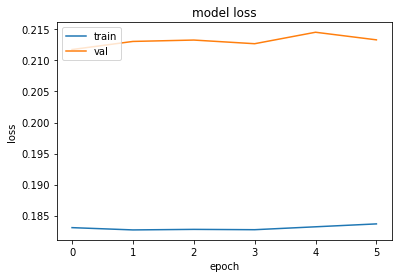

In [120]:

plt.plot(fd_hist.history['loss'],label='train')
plt.plot(fd_hist.history['val_loss'],label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Load the best saved model from above step and check predictions for test data using test_generator object to generate batches.

#### Write code in the below cell to load best saved model in the above step.

In [0]:
best_loaded_model = model.load_weights(modelFilePath+'best_weights_fg.h5',by_name=True)
best_loaded_model

### Use the below function to plot the boundingbox in the test image to show the predictions.

In [0]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, 25)).tolist()
  color_code = min(len(results), 16)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  modFileName = filename.split('.jpg')[0]+'.png'
  
  plt.savefig(path + modFileName, bbox_inches='tight')
  #plt.savefig(path + filename, bbox_inches='tight')

  #print ('saved' , path + filename)
  print ('saved' , path + modFileName)

  plt.clf()


#### Run the below code to create a folder with name output_test and get the predictions for the test images using model.predict()

In [53]:
!pwd

/content/drive/My Drive/AdvCNN/Face_Detection_Files


In [0]:
os.chdir('/content/drive/My Drive/AdvCNN/')

In [0]:
os.chdir('/content/drive/My Drive/AdvCNN/Face_Detection_Files')

In [0]:
!mkdir output_test

In [0]:
#!rm -rf output_test

In [86]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

test_size = 16
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for i in range(test_size-1):
    X, y, filenames = next(test_generator)

    y_pred = model.predict(X)
    y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


    np.set_printoptions(suppress=True)
    print(i)
    print(test_size)
    
    #print(filenames[i])

    #filename = filenames[i].split('.')[0]+filenames[i].split('.')[1]+'.png'
    #print(filename)

    save_bb("./output_test/", filenames[i], y_pred_decoded[i])
    save_bb("./output_test/", filenames[i], y[i], prediction=False)

    #save_bb("./output_test/", filenames[i], y_pred_decoded[i])
    #save_bb("./output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
0
16
total number of bbs: 2
saved ./output_test/17_Ceremony_Ceremony_17_1048.png
total number of bbs: 4
saved ./output_test/17_Ceremony_Ceremony_17_1048_gt.png
1
16
total number of bbs: 6
saved ./output_test/12_Group_Large_Group_12_Group_Large_Group_12_448.png
total number of bbs: 5
saved ./output_test/12_Group_Large_Group_12_Group_Large_Group_12_448_gt.png
2
16
total number of bbs: 1
saved ./output_test/30_Surgeons_Surgeons_30_533.png
total number of bbs: 1
saved ./output_test/30_Surgeons_Surgeons_30_533_gt.png
3
16
total number of bbs: 1
saved ./output_test/4_Dancing_Dancing_4_97.png
total number of bbs: 5
saved ./output_test/4_Dancing_Dancing_4_97_gt.png
4
16
total number of bbs: 1
saved ./output_test/4_Dancing_Dancing_4_97.png
total number of bbs: 5
saved ./output_test/4_Dancing_Dancing_4_97_gt.png
5
16
total number of bbs: 2
saved ./output_test/22_Picnic_Picnic_22_561.png
total number of bbs: 2
saved ./output_test/22_Picnic_Picnic_22_561_gt.png
6
16
total n

In the above step all the test images along with predictions are stored in output_test folder in this notebook environment. You can check the folder in Files section of the menu to left-side of screen in colab.

Each test image is used for predictions and is stored as 2 files.

one file is the original ground truth with <filename_gt.jpg>
second file is the prediction of the model on the image. with <filename.jpg>

### Visualize a test image to check predictions


#### Write code to show images: Using cv2.imshow() or matplotlib show any 3 test images and their predictions.

In [0]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

In [0]:
outputFolder = '/content/drive/My Drive/AdvCNN/Face_Detection_Files/output_test/'

In [110]:
for file in os.listdir(outputFolder):
  print(file)

17_Ceremony_Ceremony_17_1048.png
17_Ceremony_Ceremony_17_1048_gt.png
12_Group_Large_Group_12_Group_Large_Group_12_448.png
12_Group_Large_Group_12_Group_Large_Group_12_448_gt.png
30_Surgeons_Surgeons_30_533.png
30_Surgeons_Surgeons_30_533_gt.png
4_Dancing_Dancing_4_97.png
4_Dancing_Dancing_4_97_gt.png
22_Picnic_Picnic_22_561.png
22_Picnic_Picnic_22_561_gt.png
12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_101.png
12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_101_gt.png
35_Basketball_playingbasketball_35_362.png
35_Basketball_playingbasketball_35_362_gt.png
58_Hockey_icehockey_puck_58_285.png
58_Hockey_icehockey_puck_58_285_gt.png
10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_674.png
10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_674_gt.png
41_Swimming_Swimming_41_580.png
41_Swimming_Swimming_41_580_gt.png
35_Basketball_basketballgame

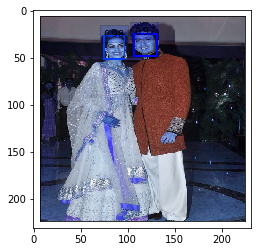

In [108]:
plt.imshow(cv2.imread(outputFolder+'17_Ceremony_Ceremony_17_1048.png'))

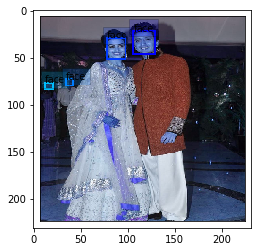

In [111]:
plt.imshow(cv2.imread(outputFolder+'17_Ceremony_Ceremony_17_1048_gt.png'))

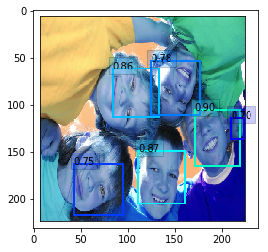

In [113]:
plt.imshow(cv2.imread(outputFolder+'12_Group_Large_Group_12_Group_Large_Group_12_448.png'))

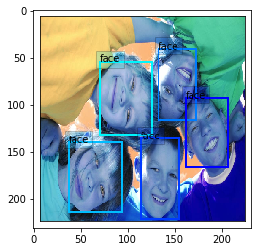

In [114]:
plt.imshow(cv2.imread(outputFolder+'12_Group_Large_Group_12_Group_Large_Group_12_448_gt.png'))

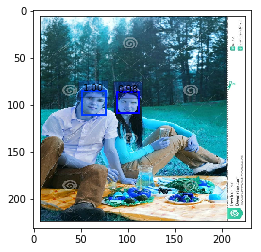

In [117]:
plt.imshow(cv2.imread(outputFolder+'22_Picnic_Picnic_22_561.png'))

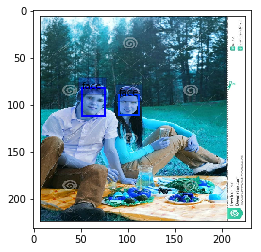

In [118]:
plt.imshow(cv2.imread(outputFolder+'22_Picnic_Picnic_22_561_gt.png'))